# Exploratory Data Analysis of Depression data

Please see project readme for details about where to download the dataset.

In [1]:
import pandas as pd
from pathlib import Path

depression_dataset_file_location = Path("../data/depression_dataset_reddit_cleaned.csv")
df = pd.read_csv(depression_dataset_file_location)

In [2]:
df.columns

Index(['clean_text', 'is_depression'], dtype='object')

In [3]:
df.is_depression.value_counts()

0    3900
1    3831
Name: is_depression, dtype: int64

Seems we have a balanced data set between comments that indicate depression and otherwise.

If the data set were not balanced, we may consider options like:
- weighting the loss function,
- oversampling the minority class, or
- undersampling the majority class

to aid with the resulting model's evaluation metrics. But, it seems that won't be necessary for this data set.

Let's get an idea of what the depression comments look like.

In [4]:
df[df.is_depression == 1].sample(10)

,clean_text,is_depression
1743,anybody else have so much anxiety over confron...,1
2313,title should ve been will it work within the h...,1
2328,i m not depressed or in depression i think the...,1
3646,metalgearobama people with depression should not,1
78,i just found out my boyfriend is depressed i r...,1
145,i think i m starting to feel an emotion that i...,1
675,something except talking to people about it i ...,1
2292,i ve been wanting to kill myself for a while b...,1
1858,i suddenly feel uneasy and uncomfortable at my...,1
1826,i am finally going to make an appointment mond...,1


In [5]:
df[df.is_depression == 0].sample(10)

,clean_text,is_depression
4424,not feeling well and back hurt,0
5464,jesmayhemwa still trying to sell the prelude,0
5615,in work sooo bored,0
4110,whinging my client amp bos don t understand en...,0
5699,planting a friend today not been to a funeral ...,0
6470,booo ee you suck why daniella don t bring sam ...,0
4958,gripping agreed love the sound but hate how ev...,0
7210,nothing much not well in bed all day,0
5047,bored and lonely,0
7039,binncheol you should listen to some music by t...,0


Initial observations:
- Whatever cleaning that the text has already gone through seems to have removed capitalization, punctuation, and has tokenized some words like "gonna", "it's"
- depression comments seem to be longer than non-depression comments - let's verify this in a cell below
- we aren't guaranteed to be dealing with full sentences or sentences with perfect spelling / grammar


In [15]:
# Are depression comments contain a higher word count?

df['word_count'] = df.clean_text.str.split().str.len()

depression_mean_word_count = df[df.is_depression == 1].word_count.mean()
not_depression_mean_word_count = df[df.is_depression == 0].word_count.mean()

print(f"Mean word count for depression comments:     {depression_mean_word_count: 4.2f}")
print(f"Mean word count for non-depression comments: {not_depression_mean_word_count: 4.2f}")

Mean word count for depression comments:     136.09
Mean word count for non-depression comments: 14.29


It seems we have some target leakage. The word count for depression comments is significantly larger than the word count for non-depression comments. It's possible the model could pick up on this. It's important that we evaluate how the model performs on longer non-depression comments and shorter depression comments.

Text(0.5, 1.0, 'All Comments Word Count Histogram')

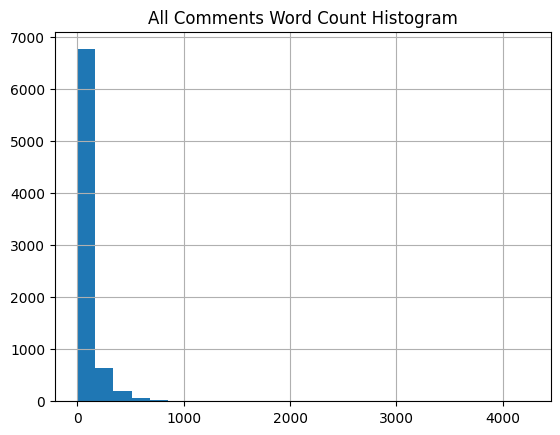

In [26]:
ax = df.hist(column="word_count", bins=25)
ax[0][0].set_title("All Comments Word Count Histogram")

Text(0.5, 1.0, 'Depression Comment Word Count Histogram')

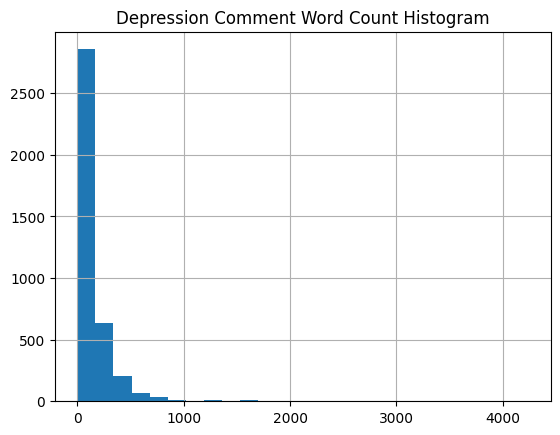

In [24]:
ax = df[df.is_depression == 1].hist(column="word_count", bins=25)
ax[0][0].set_title("Depression Comment Word Count Histogram")

Text(0.5, 1.0, 'Non-Depression Comment Word Count Histogram')

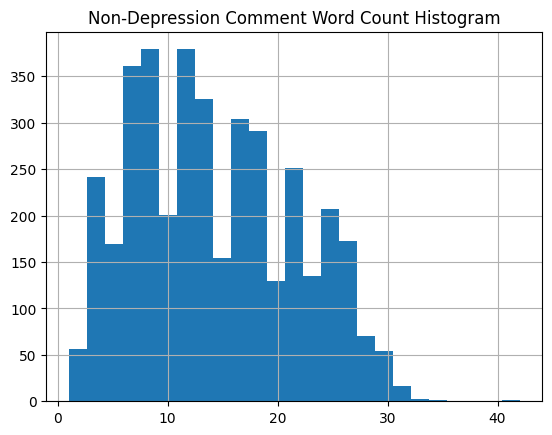

In [25]:
ax = df[df.is_depression == 0].hist(column="word_count", bins=25)
ax[0][0].set_title("Non-Depression Comment Word Count Histogram")

 Do we have any non-english data?


In [28]:
from langdetect import detect

# note this cell may take a  minute to run...

df["is_english"] = df.apply(
    lambda row: detect(row.clean_text) == "en",
    axis=1,
)

In [29]:
df.is_english.value_counts()

True     7211
False     520
Name: is_english, dtype: int64

In [31]:
df[~df.is_english].sample(10)

,clean_text,is_depression,word_count,is_english
3107,paul pogba s exprime sur la d pression dans un...,1,53,False
5116,dra on now i am sad co u r sad,0,10,False
6024,naar haddow racket mee wahey,0,5,False
3710,absalomjuma kukufa na depression,1,4,False
5796,can t sleep i don t like sonny being gone,0,10,False
3654,yung nag hahanap ka ng magandang bl tapos naha...,1,17,False
5903,juzley yaaaay maybe i should ve gone,0,7,False
5612,indiblogger do i neei dotn get any comment and...,0,10,False
5431,laurenlenewx awww i m sorry,0,5,False
3072,can t outrun depression unfortunately,1,5,False


In [39]:
# ... did.... did they just annotate by seeing if the comment contains the word depression...?

df["contains_word_depression"] = df.apply(
    lambda row: any(
        [
            "depression" in row.clean_text,
            "depressed" in row.clean_text,
            "anxiety" in row.clean_text,
        ]
    ),
    axis=1,
)

In [40]:
df[df.is_depression != df.contains_word_depression]

,clean_text,is_depression,word_count,is_english,contains_word_depression
4,sleep is my greatest and most comforting escap...,1,54,True,False
5,i m year old turning soon in a few month i liv...,1,323,True,False
7,i m not looking for sympathy just simply to st...,1,132,True,False
8,i don t know how to communicate all of my thou...,1,101,True,False
9,mom i m sad it hurt in my heart the feeling fa...,1,189,True,False
...,...,...,...,...,...
5283,need s help with this anxiety crap,0,7,True,True
5858,wow epicfail on me i did a search for epicfail...,0,26,True,True
6037,depressed our new app s alpha 0 0 0 is now eve...,0,29,True,True
7483,is depressed he isn t going to be able to see ...,0,13,True,True


Okay, no, they didn't just annotate by keyword spotting. Still, I'm not sure I understand how this data is annotated. I don't agree with some annotations.

## Conclusion

I have a loose feel for the data. We have incomplete, ungrammatical sentences (no surprise since the source is reddit). We'll need to clean out any non-english comments, realizing that we may take out some comments that are truly english but have some errors. The data annotations may have some noise, but let's try some models to see if we can differentiate the two classes.